In [507]:
import numpy as np
import pandas as pd
from scipy import signal
from matplotlib import pyplot as plt

In [508]:
data = pd.read_csv('C:\\Users\\bfesc\\Documents\\Master_thesis\\master_data\\dataport\\dataport-ev2.csv', 
                header = 0, index_col = 0)
data.index = data.index.map(lambda x: x[:-3])
data.index = pd.to_datetime(data.index)
data = data.resample('15T').mean()
data['grid'][np.isnan(data['grid'])] = np.zeros(len(data['grid'][np.isnan(data['grid'])]))
data.head()

,dataid,car1,grid
localminute,,,
2017-01-01 00:00:00,3482.0,0.000000,0.247200
2017-01-01 00:15:00,3482.0,0.006400,0.208600
2017-01-01 00:30:00,3482.0,0.000733,0.227933
2017-01-01 00:45:00,3482.0,0.005600,0.139133
2017-01-01 01:00:00,3482.0,0.006333,0.199867


In [509]:
week = 7*24*4

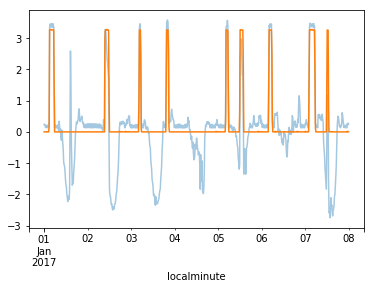

In [510]:
data['grid'][:week].plot(alpha=0.4)
data['car1'][:week].plot()
plt.show()

In [639]:
def get_signatures(power_series,min_off_duration = 0, min_on_duration = 3):
    
    signatures = []
    current_signal = []
    starts = []
    peak_times = []
    off_duration = 0
    
    for i in range(1,power_series.size):

        if power_series[i] > 1:
            if len(current_signal) == 0:
               current_signal.append(0)
            current_signal.append(power_series[i])
            off_duration = 0
        else:
            off_duration += 1
            if off_duration >= min_off_duration and len(current_signal) > min_on_duration:
                current_signal.append(0)
                signatures.append(current_signal)
                starts.append(power_series.index[i-len(current_signal)])
                peak_times.extend(power_series.index[i-len(current_signal):i])
                current_signal = []
            
    return signatures, starts, pd.to_datetime(peak_times)

def make_templates(signatures, significance = 10):
    if len(signatures) == 0:
        return []
    
    signal_lengths = [len(signature) for signature in signatures]
    templates = [np.zeros(n) for n in range(np.max(signal_lengths)+1)]
    counts = [0 for n in range(np.max(signal_lengths)+1)]
    
    for i in range(len(signatures)):
        n = len(signatures[i])
        templates[n] += signatures[i]
        counts[n] += 1
    
    for i in range(len(templates)):
        if counts[i] != 0:
            templates[i] /= counts[i]
    
    i = 0
    while i < len(templates):
        
        if counts[i] < significance: #significance criteria
            del templates[i]
            del counts[i]
        else:
            i+=1
    
    return templates

In [512]:
signatures, signal_starts, signal_times = get_signatures(data['car1'])

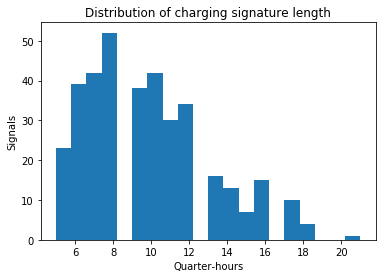

In [513]:
plt.hist([len(s) for s in signatures],bins=20)
plt.title("Distribution of charging signature length")
plt.xlabel("Quarter-hours")
plt.ylabel("Signals")
plt.show()

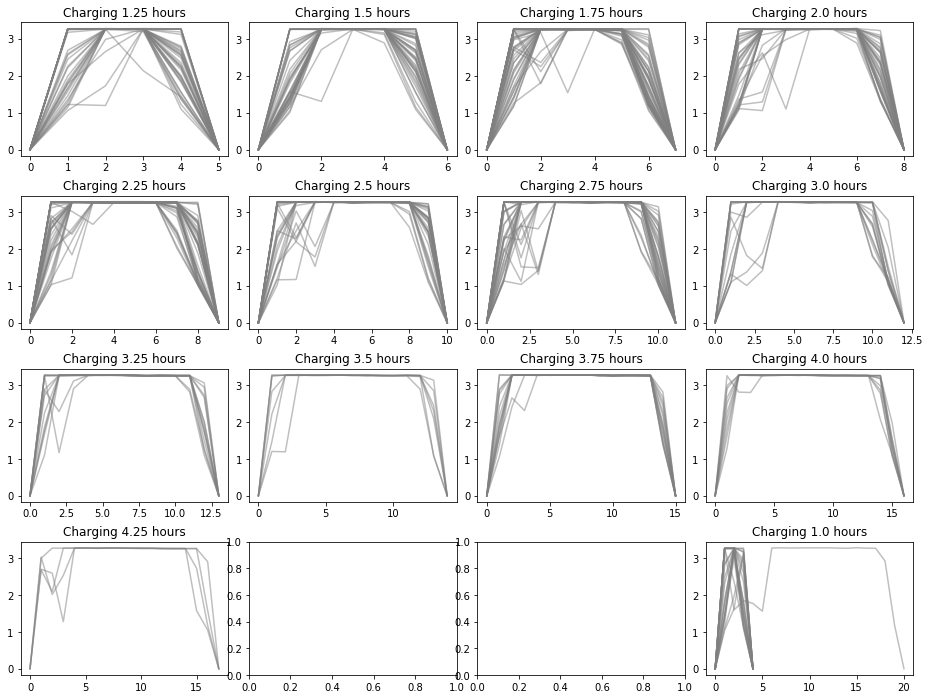

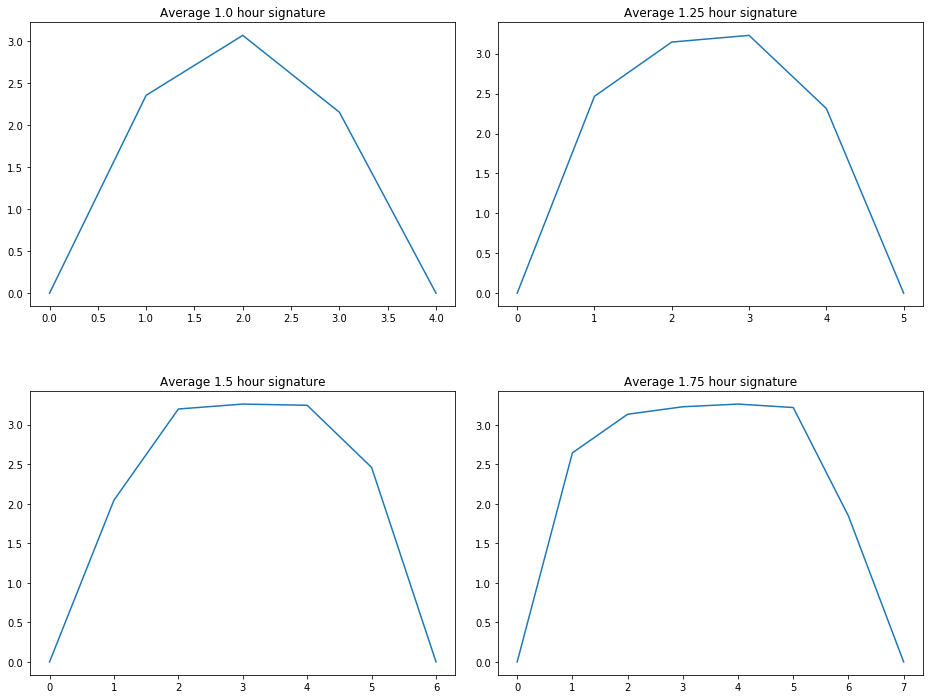

In [514]:
tot = np.zeros(10)
fig, axarr = plt.subplots(4,4,sharex=False)
plt.subplots_adjust(hspace=0.3,wspace=0.1)
fig.set_size_inches(16,12)
totals = [np.zeros(i) for i in range(22)]
counts = np.zeros(22)

for i in range(len(signatures)):
    n = len(signatures[i])
    axarr[int(np.floor((n-6)/4)),int((n-6)%4)].plot(signatures[i],color='grey',alpha=0.5)
    axarr[int(np.floor((n-6)/4)),int((n-6)%4)].set_title("Charging "+ str((n-1)/4) + " hours")
    for j in range(n):
        totals[n][j] += signatures[i][j]
    counts[n] += 1
plt.show()

for i in range(len(counts)):
    if counts[i] != 0:
        totals[i] /= counts[i]

fig,axarr = plt.subplots(2,2,sharex=False)
plt.subplots_adjust(hspace=0.3,wspace=0.1)
fig.set_size_inches(16,12)

for i in range(5,9):
    axarr[int(np.floor((i-5)/2)),int((i-5)%2)].plot(totals[i])
    axarr[int(np.floor((i-5)/2)),int((i-5)%2)].set_title("Average " + str((i-1)/4) + " hour signature")
plt.show()

Possible plan:<br>
1) For each charging signature length, make a "typical" signal. By averaging or some other method.<br>
2) Convolute all typical signals, thresholding on some cross-correlation value to discover charging events<br>
3) Calculate some performance metric. The goal should be discovering and simply tagging the charging events.<br>
**Is this useful? The signatures don't appear to have any particular characteristic, other than ranging from 1 to 5 hours in length, so a matched filter may not be a particularly good solution.**

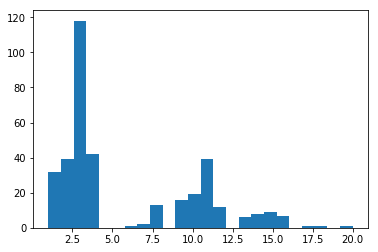

In [516]:
plt.hist([time.hour for time in signal_starts],bins=24)
plt.show()

### ???
These guys charge their EV at 3AM

(672,)
(672,)


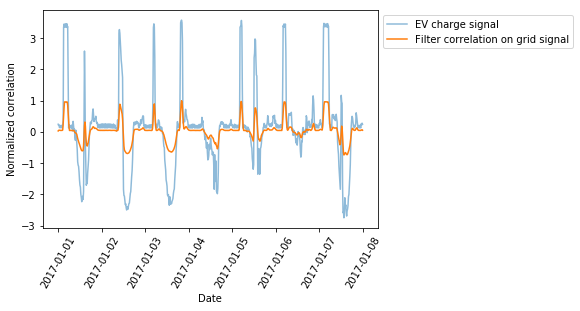

In [517]:
xcorr = signal.correlate(data['grid'][:week], totals[6], mode='same')

print(xcorr.shape)
print(data['car1'][:week].shape)
plt.plot(data['grid'][:week],alpha=0.5)
plt.plot(data['car1'][:week].index,xcorr/xcorr.max())
plt.xticks(rotation=60)
plt.ylabel("Normalized correlation")
plt.xlabel("Date")
plt.legend(["EV charge signal","Filter correlation on grid signal"],bbox_to_anchor=(1, 1))
plt.show()

This seems to work surprisingly well even with a rudimentary filter using only 6 hour signals.

In [467]:
def find_signals(data, templates, threshold=0.4, mode='same', interval = 10):
    #Finds the events corresponding to a cross correlation between the data and at least one template of above threshold.

    timeline = pd.DataFrame(np.zeros(data.shape[0]),index = data.index)
    for template in templates:
        
        if sum(template) == 0:
            continue
            
        xcorr = signal.correlate(data, template, mode=mode)
        xcorr /= xcorr.max()

        events = []
        i=0
        
        while i < len(xcorr):
            if xcorr[i] >= threshold and np.sum(timeline.loc[data.index[i-interval]:data.index[i+interval]])[0] == 0:
                timeline.loc[data.index[i]] += 1
                while xcorr[i] >= threshold:
                    i += 1
            i+=1
    
    return timeline.where(timeline > 0).dropna().index

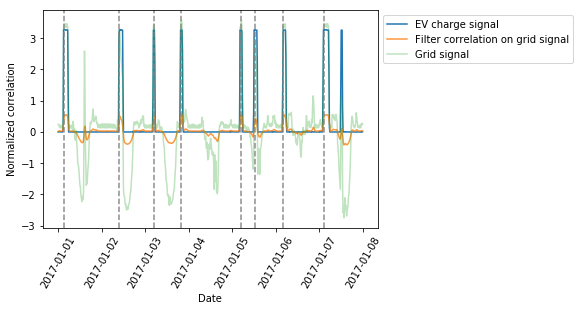

In [523]:
signals = find_signals(data['grid'], [totals[i] for i in range(len(totals))],threshold=0.4)

plt.plot(data['car1'][:week])
plt.plot(data['car1'][:week].index,full_xcorr[:week], alpha=0.8)
plt.plot(data['grid'][:week],alpha = 0.3)
plt.ylabel("Normalized correlation")
plt.xlabel("Date")
plt.legend(["EV charge signal","Filter correlation on grid signal","Grid signal"],bbox_to_anchor=(1, 1))
plt.xticks(rotation=60)
for line in signals[:8]:
    plt.axvline(line, linestyle='--',alpha=0.9,color='grey')

plt.show()

In [476]:
def filter_score(signal_times,signals_hat,n_signals):
    #True positives
    tp = np.where(np.in1d(signals_hat,signal_times))[0].shape[0]
    #False positives
    fp = np.where(np.in1d(signals_hat,signal_times,invert=True))[0].shape[0]
    #Precision
    precision = tp/(tp+fp)
    #Recall
    recall = tp/n_signals
    #F1-measure
    f1 = (2*precision*recall) / (precision + recall)
    #print('Precision: {}\nRecall: {}\nF1-score: {}'.format(precision,recall,f1))
    
    return precision,recall,f1

In [661]:
precisions1 = []
recalls1 = []
f1s1 = []
threshold_range = np.linspace(0.3,0.8,50)

for i in np.linspace(0.3,0.8,50):
    s = find_signals(data['grid'], [totals[j] for j in range(len(totals))],threshold=i)
    p,r,f1 = filter_score(signal_times,s,len(signal_starts))
    precisions1.append(p)
    recalls1.append(r)
    f1s1.append(f1)

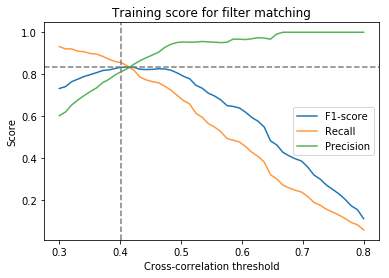

Max F1: 0.833555259653795


In [663]:

plt.plot(threshold_range, f1s1)
plt.plot(threshold_range, recalls1, alpha=0.8)
plt.plot(threshold_range, precisions1, alpha=0.8)
plt.title("Training score for filter matching")
plt.legend(["F1-score","Recall","Precision"])
plt.axhline(np.max(f1s1), color='grey', linestyle='--')
plt.axvline(threshold_range[np.argmax(f1s1)], color='grey', linestyle='--')
plt.xlabel("Cross-correlation threshold")
plt.ylabel("Score")
plt.show()
print("Max F1: {}".format(np.max(f1s1)))

## Further testing and generalization
The following section uses ten more houses to further explore the effectiveness of the filter matching.

In [560]:
data2 = pd.read_csv('C:\\Users\\bfesc\\Documents\\Master_thesis\\master_data\\dataport\\dataport-ev-10houses.csv', 
                header = 0, index_col = 0)
data2.index = data2.index.map(lambda x: x[:-3])
data2.index = pd.to_datetime(data2.index)
data2 = data2.astype(np.float64)
data2.head()

,dataid,car1,grid
localminute,,,
2017-01-01,26.0,0.005,2.969
2017-01-01,1354.0,0.000,0.266
2017-01-01,114.0,0.000,0.632
2017-01-01,1169.0,0.000,0.469
2017-01-01,379.0,0.005,1.219


In [611]:
ev_signals = pd.DataFrame(index = data2[data2['dataid'] == data2['dataid'][0]].index)
grid_signals = pd.DataFrame(index = data2[data2['dataid'] == data2['dataid'][0]].index)
for i in np.unique(data2['dataid']):
    if len(data2[data2['dataid'] == i]['car1']) == len(ev_signals.index):
        ev_signals[str(i)] = data2[data2['dataid'] == i]['car1']
        grid_signals[str(i)] = data2[data2['dataid'] == i]['grid']
    
ev_signals = ev_signals.resample('15T').mean()
ev_signals.fillna(method='backfill',inplace=True)
ev_signals = ev_signals.T

grid_signals = grid_signals.resample('15T').mean()
grid_signals.fillna(method='backfill',inplace=True)
grid_signals = grid_signals.T

grid_signals.head(10)

localminute,2017-01-01 00:00:00,2017-01-01 00:15:00,2017-01-01 00:30:00,2017-01-01 00:45:00,2017-01-01 01:00:00,2017-01-01 01:15:00,2017-01-01 01:30:00,2017-01-01 01:45:00,2017-01-01 02:00:00,2017-01-01 02:15:00,...,2017-12-31 15:30:00,2017-12-31 15:45:00,2017-12-31 16:00:00,2017-12-31 16:15:00,2017-12-31 16:30:00,2017-12-31 16:45:00,2017-12-31 17:00:00,2017-12-31 17:15:00,2017-12-31 17:30:00,2017-12-31 17:45:00
26.0,2.759267,1.903067,1.472467,1.020333,1.781867,1.765800,0.565000,0.781933,0.741533,0.610000,...,1.251267,0.676133,0.693533,0.756000,0.985200,3.157000,2.694533,2.480733,2.618133,2.347867
114.0,0.632800,0.571400,0.504000,0.499800,0.562000,0.248333,0.385067,0.382933,0.304600,0.307800,...,1.446467,1.664533,1.555400,2.408933,1.502867,1.591200,1.899867,3.006733,2.609200,2.173133
370.0,0.590667,0.597600,0.589933,1.672000,4.321933,4.314667,3.938533,3.784733,1.566333,0.443600,...,1.239333,0.930467,0.770067,0.825667,0.879067,0.611667,0.600200,0.623933,0.627333,0.630933
379.0,1.210467,1.136200,1.022933,1.301000,1.427867,1.006667,0.757400,0.816733,1.409800,1.272200,...,1.295533,0.835333,1.436267,1.414600,1.072400,1.720333,1.629400,1.763267,1.292000,1.744667
1169.0,0.501333,0.464333,0.770467,0.467000,0.514533,0.460733,0.413667,0.340800,0.399533,0.447867,...,0.684467,0.332000,0.259667,0.666933,0.648467,0.717600,0.587067,0.504467,0.567600,0.687067
1202.0,1.032533,2.120533,1.694533,0.700267,0.668733,0.992400,0.791600,0.656667,0.695933,1.008800,...,2.390600,1.735267,2.481600,1.976333,2.088933,2.374800,2.135733,2.787800,3.887867,2.974267
1354.0,0.198933,0.212467,0.265200,0.213133,0.366933,0.379867,0.371933,0.305000,0.461000,0.475733,...,0.656267,0.612400,0.618467,0.513733,0.315867,0.309667,0.440600,1.034800,1.380400,0.846867


In [640]:
templates = []

for house in ev_signals.index:
    charging_signals, _, _ = get_signatures(ev_signals.loc[house])
    house_templates = make_templates(charging_signals)
    templates.extend(house_templates)


In [655]:
meta_templates = []

for i in range(np.max([len(template) for template in templates])):
    templates_n = [template for template in templates if len(template) == i]
    if len(templates_n) > 0:
        meta_templates.append(np.mean(templates_n,axis=0))
#         plt.plot(template_n)
#         plt.show()

In [656]:
precisions = []
recalls = []
f1s = []
threshold_range = np.linspace(0.3,0.8,50)

for i in np.linspace(0.3,0.8,50):
    s = find_signals(data['grid'], [meta_templates[j] for j in range(len(meta_templates))],threshold=i)
    p,r,f1 = filter_score(signal_times,s,len(signal_starts))
    precisions.append(p)
    recalls.append(r)
    f1s.append(f1)

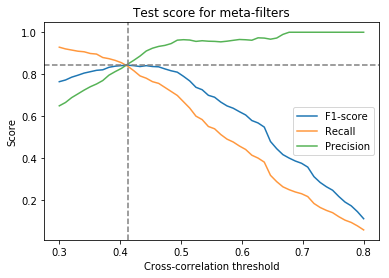

Max F1: 0.8434065934065934


In [660]:

plt.plot(threshold_range, f1s)
plt.plot(threshold_range, recalls, alpha=0.8)
plt.plot(threshold_range, precisions, alpha=0.8)
plt.title("Test score for meta-filters")
plt.legend(["F1-score","Recall","Precision"])
plt.axhline(np.max(f1s), color='grey', linestyle='--')
plt.axvline(threshold_range[np.argmax(f1s)], color='grey', linestyle='--')
plt.xlabel("Cross-correlation threshold")
plt.ylabel("Score")
plt.show()
print("Max F1: {}".format(np.max(f1s)))

At an F-score of 0.84, the method is probably not very useful for discovering the exact number of EV-charging events taking place in a power series. However it may be useful for other things, such as estimating the probability of household EV's (including the number of cars). It may also be interesting to see how the score varies from household to household in order to discover differences in the charging signatures.